# ReLU in 1-layer model with NLGP dataset

1. Confirming effect of gain parameter on localization is same with ReLU \& sigmoid activations
   1. It is: we go from localization to long-range oscillations in both cases (which converges to flat, I think?)
2. What happens if we make $K=1$, as we'd like to do when analyzing ReLU dynamics?

In [247]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments.batched_online import simulate, make_key

from utils import ipr, entropy, entropy_sort, mean_sort, var_sort, plot_receptive_fields, plot_rf_evolution

def simulate_or_load(**kwargs):
    path_key = make_key(**kwargs)
    if path_key + '.npz' in os.listdir('../localization/results/weights'):
        print('Already simulated')
        data = np.load('../localization/results/weights/' + path_key + '.npz', allow_pickle=True)
        weights_, metrics_ = data['weights'], data['metrics']
    else:
        print('Simulating')
        weights_, metrics_ = simulate(**kwargs)
    return weights_, metrics_

def build_gaussian_covariance(L, xi):
    C = np.abs(jnp.tile(jnp.arange(L)[:, jnp.newaxis], (1, L)) - jnp.tile(jnp.arange(L), (L, 1)))
    C = jnp.minimum(C, L - C)
    C = np.exp(-C ** 2 / (xi ** 2))
    return C

config_ = dict(
  seed=0,
  num_dimensions=40,
  model_cls=models.SimpleNet,
  optimizer_fn=optax.sgd,
  batch_size=10000,
  dataset_cls=datasets.NonlinearGPDataset,
  support=(-1, 1),
  class_proportion=0.5,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  save_=True,
  xi1=2,
  xi2=1,
  activation='relu',
  evaluation_interval=20,
)

### Discrete Fourier Transform

In [243]:
# discrete Fourier transform
n = config['num_dimensions']
DFT = np.zeros((n, n), dtype=complex)
w = np.exp(-2 * np.pi * 1j / n)
for i in range(F.shape[0]):
    DFT[:, i] = w ** (i * np.arange(n))

DFT = np.matrix(DFT) / np.sqrt(n)
DCT = DFT.real
DST = DFT.imag

DRT = np.sqrt(2) * np.concatenate((DCT[:, :(n//2+1)], DST[:, 1:(n//2)]), axis=1)
DRT[:,0] /= np.sqrt(2)
DRT[:,n//2] /= np.sqrt(2)
DRT_ = np.matrix(np.zeros((n, n)))
DRT_[:,0] = DRT[:,0]
DRT_[:,1::2] = DRT[:,1:n//2+1]
DRT_[:,2::2] = DRT[:,n//2+1:]
DRT = DRT_

xi1 = 2
[[1.00000003 1.00000004 1.00000004 1.00000003 1.00000003 1.00000004
  1.00000004 1.00000003 1.         1.00000005 1.00000005 1.00000003
  1.00000003 1.00000009 1.00000009 1.00000097 1.000001   1.00050732
  1.00050732 1.12544621 1.12544621 1.02351255 1.02351255 1.00000643
  1.00000641 1.0000003  1.0000003  1.00000003 1.00000003 1.00000005
  1.00000005 1.00000003 0.99999998 1.00000003 1.00000003 1.00000003
  1.00000003 1.00000005 1.00000005 1.00000002]]


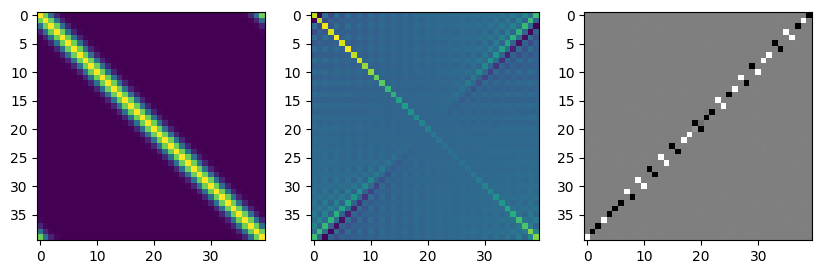

In [244]:
xi1 = 2 # config['xi1']
print('xi1 =', xi1)
Sigma = build_gaussian_covariance(n, xi1)
D, P = np.linalg.eigh(Sigma)
Lambda = DRT @ Sigma @ DRT.H
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
_ = ax1.imshow(Sigma)
_ = ax2.imshow(Lambda)
_ = ax3.imshow(P.T @ DRT, cmap='gray')
print( np.abs(P.T @ DRT).sum(axis=0) )
# is this just numerical error?

In [323]:
L = 40
C = np.abs(jnp.tile(jnp.arange(L)[:, jnp.newaxis], (1, L)) - jnp.tile(jnp.arange(L), (L, 1)))
C = jnp.minimum(C, L - C)
# DRT @ C @ DRT.H
D_, P_ = np.linalg.eigh(C.astype(float))

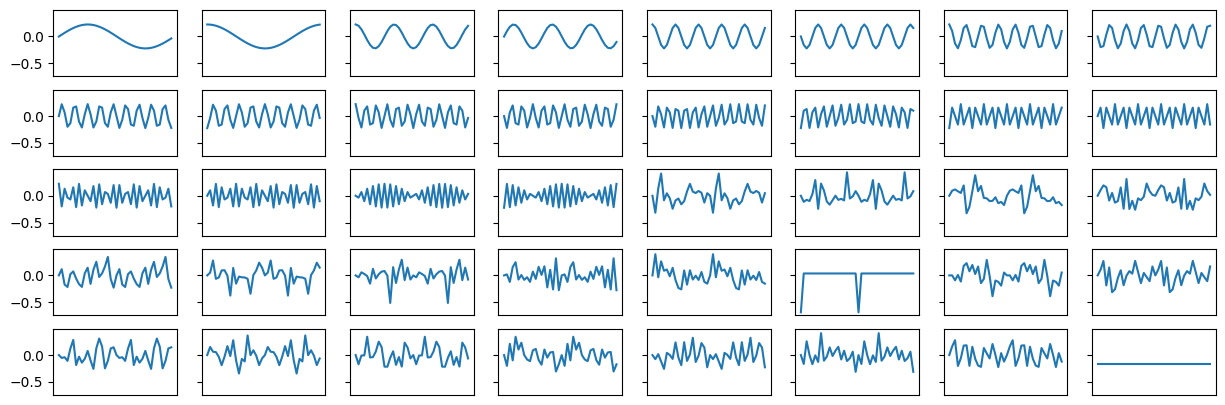

In [324]:
fig, axs = plt.subplots(5, 8, figsize=(15, 5), sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.plot(P_[:, i])
    ax.set_xticks([])

In [325]:
D_

array([-1.6244763e+02, -1.6244763e+02, -1.8349722e+01, -1.8349722e+01,
       -6.8284273e+00, -6.8284273e+00, -3.6629400e+00, -3.6629400e+00,
       -2.3708887e+00, -2.3708887e+00, -1.7294538e+00, -1.7294538e+00,
       -1.3755248e+00, -1.3755248e+00, -1.1715729e+00, -1.1715729e+00,
       -1.0576378e+00, -1.0576378e+00, -1.0061940e+00, -1.0061940e+00,
       -9.3967680e-14, -5.0204818e-14, -3.5479588e-14, -2.3034187e-14,
       -1.8270778e-14, -1.4442533e-14, -2.3656487e-15, -8.6960844e-16,
        8.1580422e-16,  4.0858383e-15,  5.2594207e-15,  6.6520263e-15,
        1.1365019e-14,  1.7188308e-14,  2.6758038e-14,  3.1384075e-14,
        3.7182368e-14,  4.9048019e-14,  5.4185182e-14,  4.0000000e+02],
      dtype=float32)

TypeError: Image data of dtype complex128 cannot be converted to float

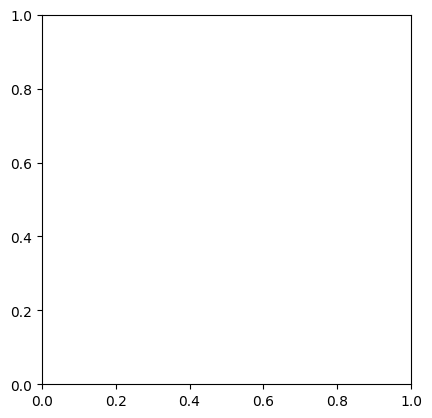

In [317]:
im = plt.imshow(DRT.T @ P_, cmap='gray')
plt.colorbar(im)

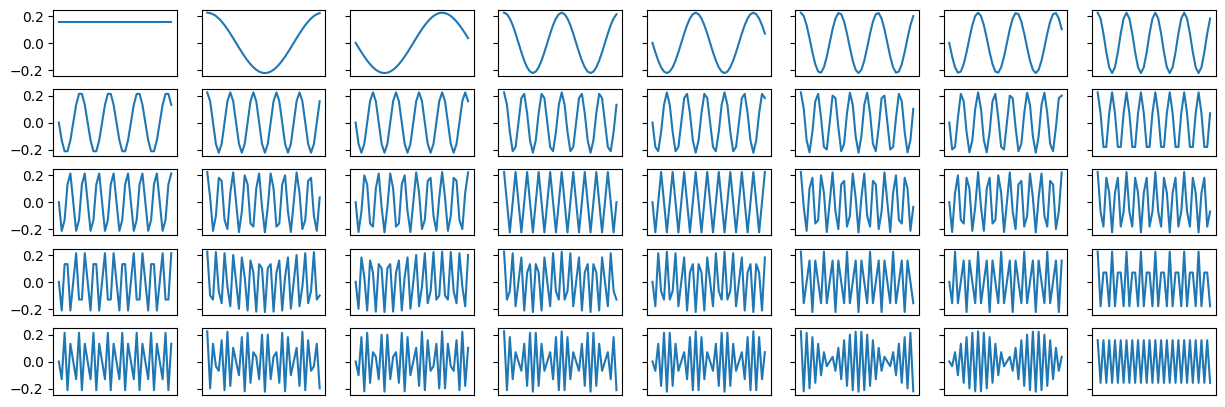

In [245]:
fig, axs = plt.subplots(5, 8, figsize=(15, 5), sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.plot(DRT[:, i])
    ax.set_xticks([])

### ReLU activation

Already simulated


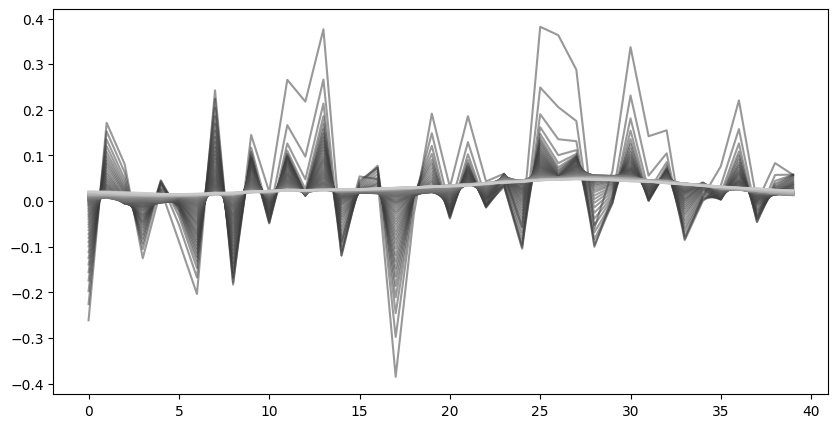

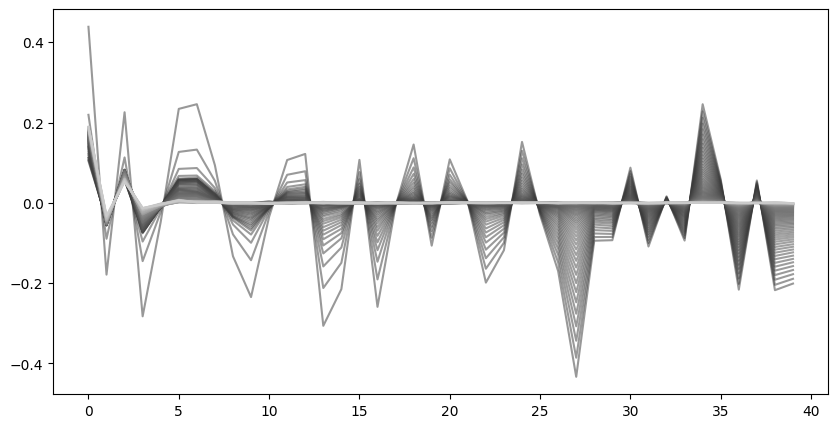

In [274]:
config = config_.copy()
config['num_hiddens'] = 1
config['learning_rate'] = 0.01
config['num_epochs'] = 2000
config['use_bias'] = False
config['init_scale'] = 1.0
config['gain'] = 0.001
config['seed'] = 42

weights, metrics = simulate_or_load(**config)
# in real space
fig, axs = plot_rf_evolution(weights, num_cols=1, num_rows=1, figsize=(10, 5))
# in Fourier space
weights_ = np.asarray(np.inner(weights, DRT.T)).reshape(-1, 1, n)
fig, axs = plot_rf_evolution(weights_, num_cols=1, num_rows=1, figsize=(10, 5))

Already simulated


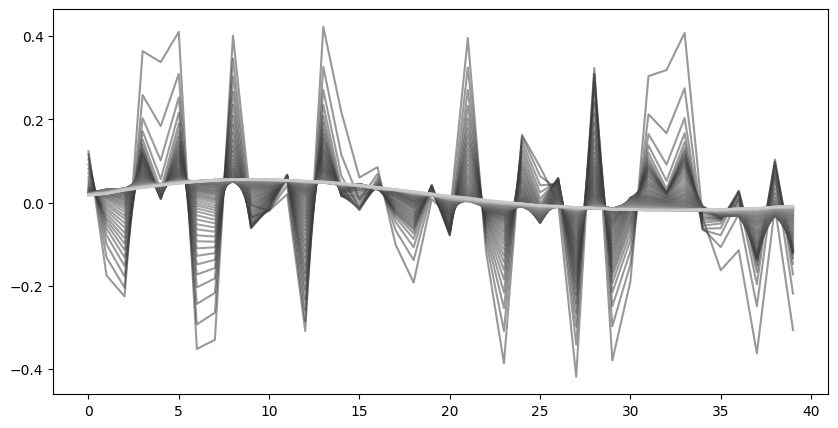

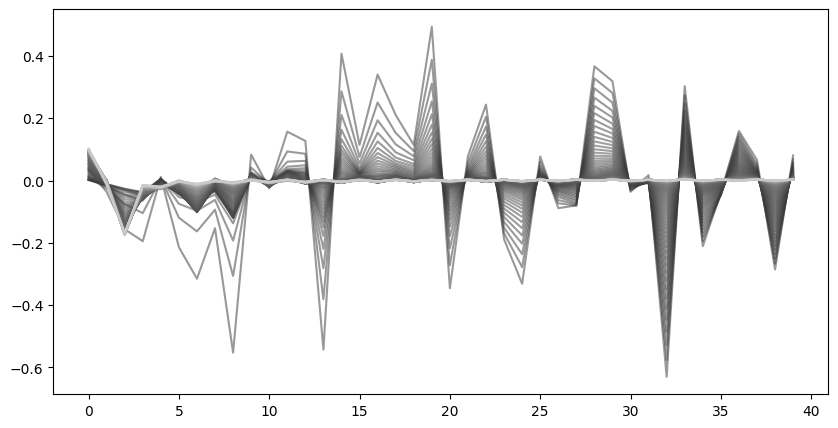

In [275]:
config = config_.copy()
config['num_hiddens'] = 1
config['learning_rate'] = 0.01
config['num_epochs'] = 2000
config['use_bias'] = False
config['init_scale'] = 1.0
config['gain'] = 0.01

weights, metrics = simulate_or_load(**config)
# in real space
fig, axs = plot_rf_evolution(weights, num_cols=1, num_rows=1, figsize=(10, 5))
# in Fourier space
weights_ = np.asarray(np.inner(weights, DRT.T)).reshape(-1, 1, n)
fig, axs = plot_rf_evolution(weights_, num_cols=1, num_rows=1, figsize=(10, 5))

In [378]:
np.array([1 + 1j]).conj()

array([1.-1.j])

/Users/leonlufkin/opt/anaconda3/envs/ML/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


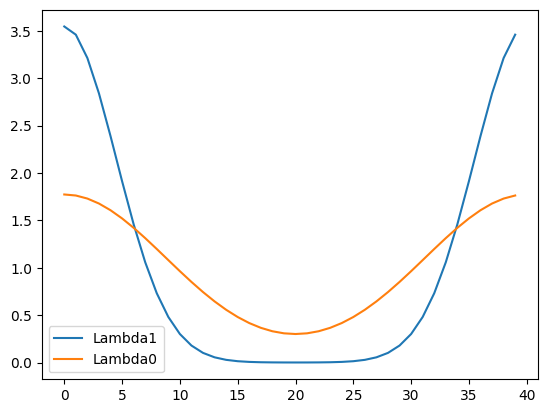

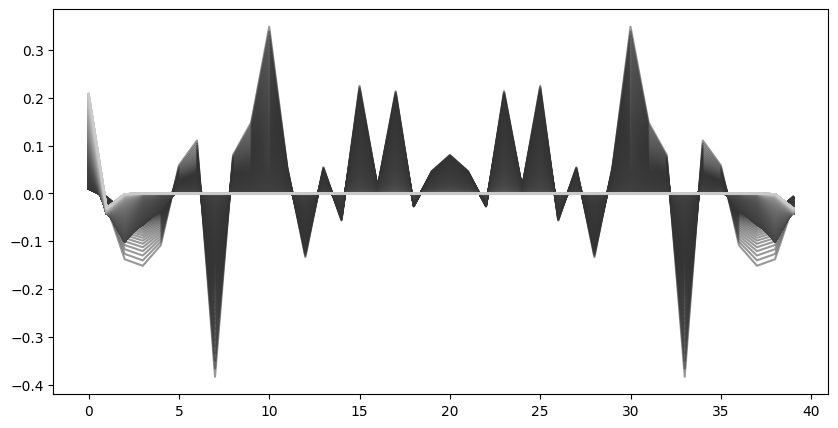

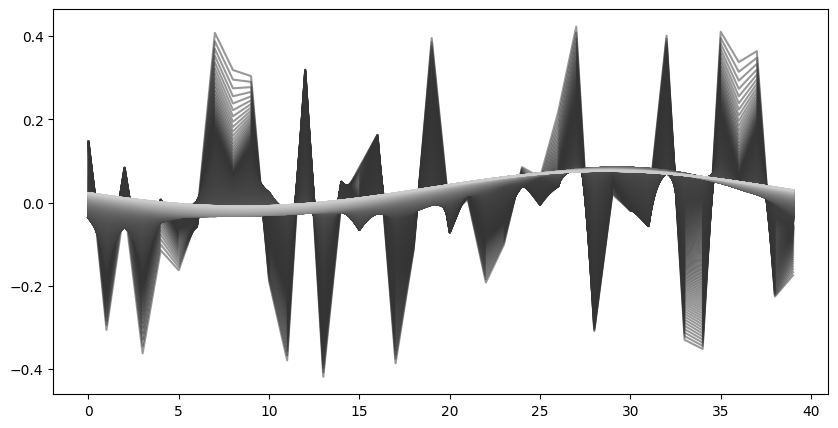

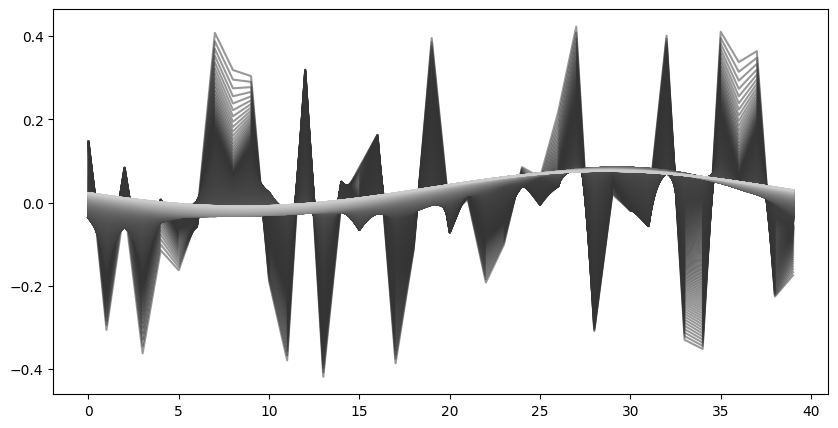

In [385]:
# theory
Sigma1 = build_gaussian_covariance(n, config['xi1'])
Sigma0 = build_gaussian_covariance(n, config['xi2'])
Lambda1, Lambda0 = DFT @ Sigma1 @ DFT.H, DFT @ Sigma0 @ DFT.H
# Lambda1, Lambda0 = np.matrix(Lambda1.real), np.matrix(Lambda0.real)
Lambda1, Lambda0 = np.diag(Lambda1.real), np.diag(Lambda0.real)
plt.plot(Lambda1, label='Lambda1')
plt.plot(Lambda0, label='Lambda0')
plt.legend()
u1 = np.zeros((config['num_epochs'], n), dtype=complex)
diag = np.zeros((config['num_epochs'], n), dtype=complex)
u1[0] = DFT.H @ weights[0][0].astype(complex)
lr = config['learning_rate']
for t in range(1, config['num_epochs']):
    u1_ = u1[t-1]
    # norm_ = np.asarray(u1_.T @ Lambda1 @ u1_)[0][0]
    norm_ = ( u1_.conj() * Lambda1 * u1_ ).sum()
    diag[t] = Lambda0 + ( 1 - np.sqrt(2/np.pi) * (1 / np.sqrt(norm_)) ) * Lambda1
    step = -0.25 * diag[t] * u1_
    u1[t] = 10 * lr * step + u1_
# in Fourier space
fig, axs = plot_rf_evolution(u1.reshape(-1, 1, n), num_cols=1, num_rows=1, figsize=(10, 5))
# in real space
u1_ = np.asarray(np.inner(u1, DFT.real - 1j * DFT.imag))
fig, axs = plot_rf_evolution(u1_.real.reshape(-1, 1, n), num_cols=1, num_rows=1, figsize=(10, 5))
# in real space
u1_ = np.asarray(np.inner(u1, DFT.real - 1j * DFT.imag))
fig, axs = plot_rf_evolution(u1_.real.reshape(-1, 1, n), num_cols=1, num_rows=1, figsize=(10, 5))

In [382]:
u1

array([[ 1.23219073e-01, -1.74999088e-01, -2.25769013e-01, ...,
        -3.62308949e-01, -1.02321040e-02, -3.06178510e-01],
       [ 1.11988839e-01, -1.59296907e-01, -2.06429184e-01, ...,
        -3.33531350e-01, -9.35560130e-03, -2.78705964e-01],
       [ 1.02126857e-01, -1.45482035e-01, -1.89321753e-01, ...,
        -3.07861734e-01, -8.58027345e-03, -2.54535456e-01],
       ...,
       [ 2.46755390e-01, -6.86838417e-02, -8.86978627e-04, ...,
        -1.60088831e-06, -4.01988626e-05, -1.20169291e-01],
       [ 2.46802936e-01, -6.86412488e-02, -8.84395202e-04, ...,
        -1.59082974e-06, -4.00817789e-05, -1.20094770e-01],
       [ 2.46850431e-01, -6.85986662e-02, -8.81819109e-04, ...,
        -1.58083406e-06, -3.99650275e-05, -1.20020268e-01]])

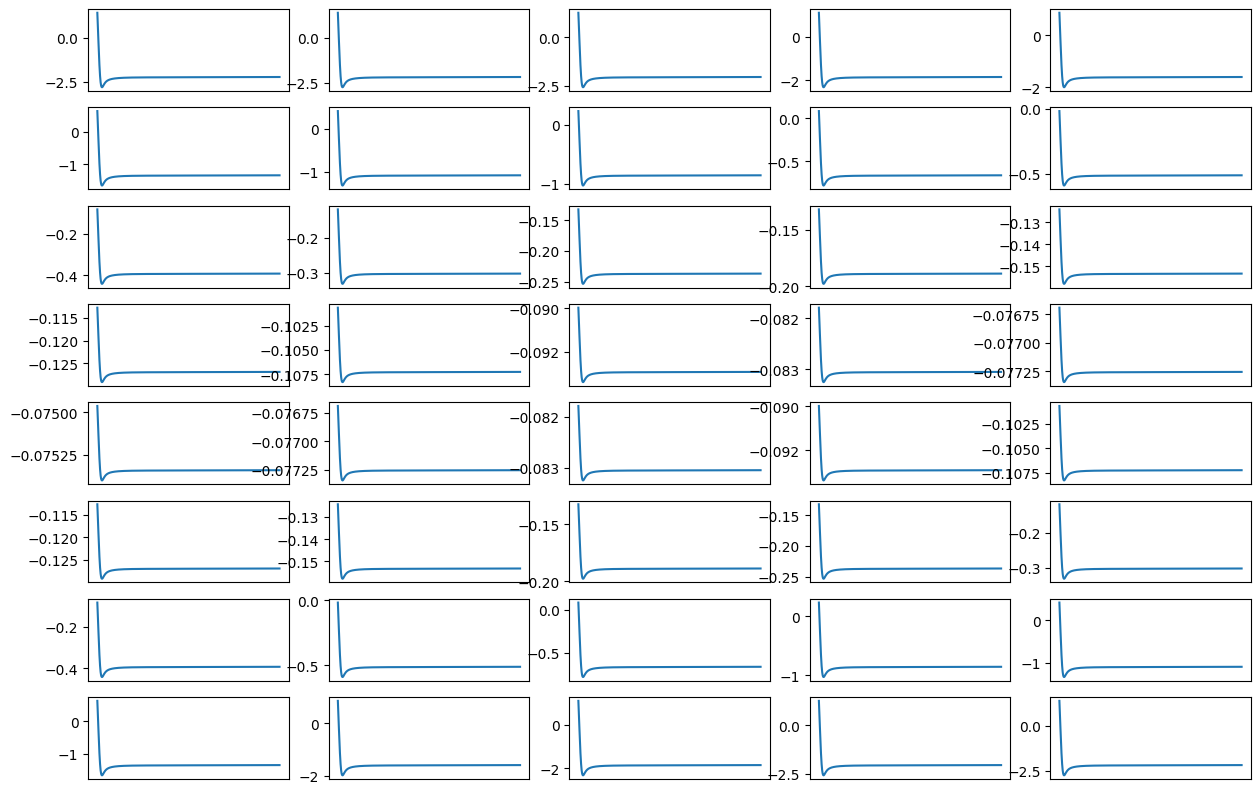

In [373]:
# fig, axs = plt.subplots(8, 5, figsize=(15, 10), sharey=True)
# for i, ax in enumerate(axs.flatten()):
#     ax.plot(diag[:, i])
#     ax.set_xticks([])

s = 1 - np.sqrt(2/np.pi) / np.sqrt(np.sum(np.square(u1) * Lambda1, axis=1))
d = -0.25 * Lambda0.reshape(1, -1) + (s.reshape(-1, 1) * Lambda1.reshape(1, -1))
fig, axs = plt.subplots(8, 5, figsize=(15, 10))#, sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.plot(d[:, i])
    ax.set_xticks([])

Already simulated


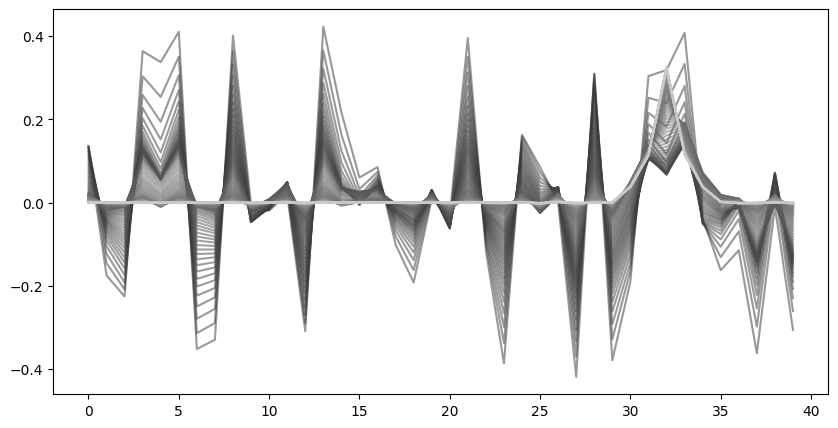

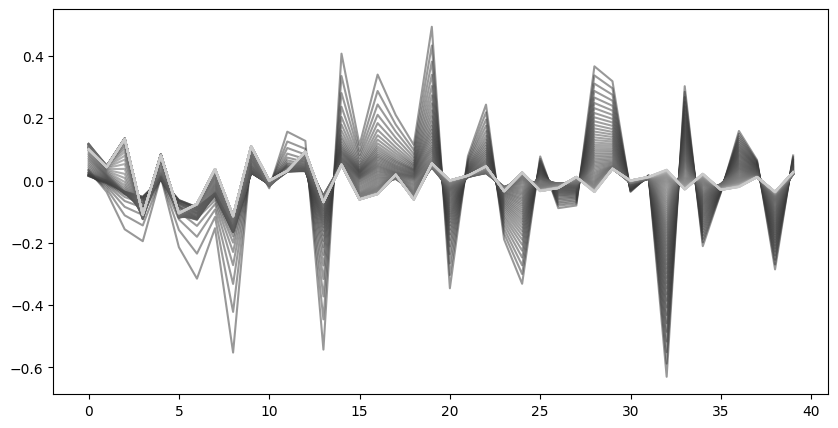

In [271]:
config = config_.copy()
config['num_hiddens'] = 1
config['learning_rate'] = 0.01
config['num_epochs'] = 2000
config['use_bias'] = False
config['init_scale'] = 1.0
config['gain'] = 3.

weights, metrics = simulate_or_load(**config)
# in real space
fig, axs = plot_rf_evolution(weights, num_cols=1, num_rows=1, figsize=(10, 5))
# in Fourier space
weights_ = np.asarray(np.inner(weights, DRT.T)).reshape(-1, 1, n)
fig, axs = plot_rf_evolution(weights_, num_cols=1, num_rows=1, figsize=(10, 5))

Simulating
Using JAX backend: cpu

Using configuration:
{'activation': 'relu',
 'batch_size': 10000,
 'class_proportion': 0.5,
 'dataset_cls': <class 'localization.datasets.nonlinear_gp.NonlinearGPDataset'>,
 'evaluation_interval': 20,
 'gain': 3.0,
 'init_fn': <function xavier_normal_init at 0x14e9f6d40>,
 'init_scale': 1.0,
 'kwargs': {},
 'learning_rate': 0.01,
 'model_cls': <class 'localization.models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 2000,
 'num_hiddens': 1,
 'optimizer_fn': <function sgd at 0x14d7b80e0>,
 'sampler_cls': <class 'localization.samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 0,
 'support': (-1, 1),
 'use_bias': False,
 'wandb_': False,
 'xi1': 2,
 'xi2': 1}

Length of train dataset: 20000000
Length of eval dataset: 1000
Length of train sampler: 20000000
Length of eval sampler: 1000
Model:
SimpleNet(
  fc1=Linear(
    weight=f32[1,40],
    bias=None,
    in_features=40,
    out_features=1,
    use_bias=False
  ),
  act=<wrapped func

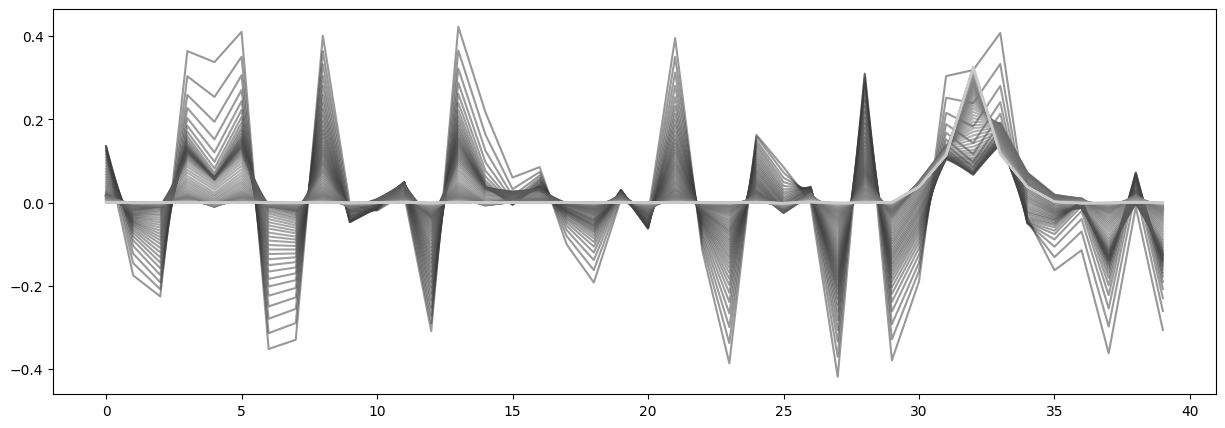

In [28]:
# what if we make w1(0) \propto 1 (+ noise)?
config = config_.copy()
config['num_hiddens'] = 1
config['learning_rate'] = 0.01
config['num_epochs'] = 2000
config['use_bias'] = False
# config['init_fn'] = lambda weight, key, scale: scale * (1. + models.xavier_normal_init(weight, key, 0.1))
config['init_scale'] = 1. #0.01
config['gain'] = 3.

weights, metrics = simulate_or_load(**config)
fig, axs = plot_rf_evolution(weights, num_cols=1, num_rows=1)

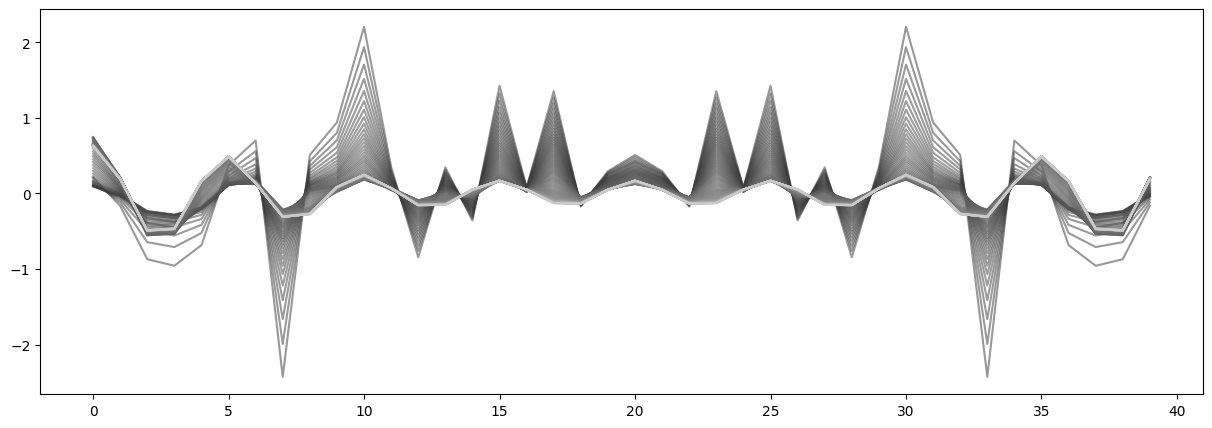

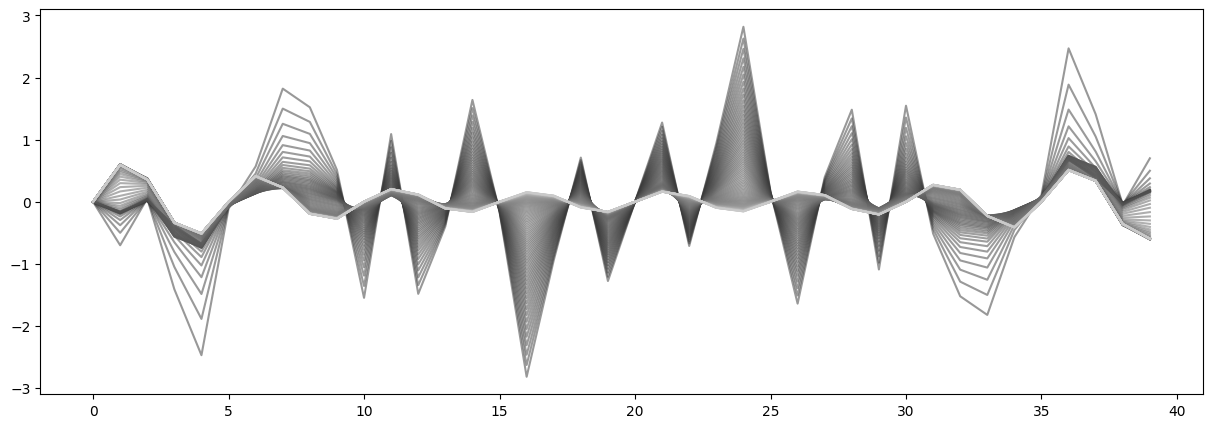

In [65]:
# discrete Fourier transform
F = np.zeros((config['num_dimensions'], config['num_dimensions']), dtype=complex)
w = np.exp(2 * np.pi * 1j / config['num_dimensions'])
for i in range(F.shape[0]):
    F[:, i] = w ** (i * np.arange(F.shape[0]))
weights_ = np.dot(weights, F.real - 1j * F.imag)
fig, axs = plot_rf_evolution(weights_.real, num_cols=1, num_rows=1)
fig, axs = plot_rf_evolution(weights_.imag, num_cols=1, num_rows=1)

xi1 = 5, xi2 = 2


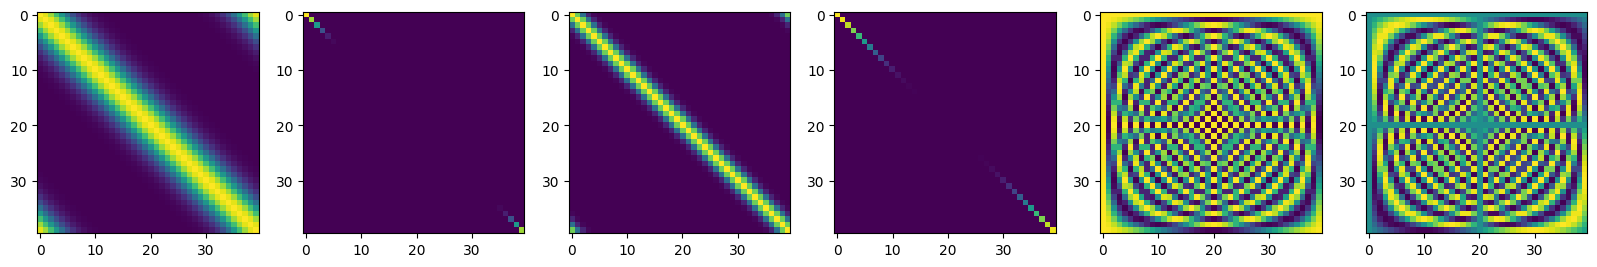

In [72]:
xi1, xi2 = 5, 2 #config['xi1'], config['xi2']
print('xi1 = {}, xi2 = {}'.format(xi1, xi2))
Sigma1 = build_gaussian_covariance(config['num_dimensions'], xi1)
Sigma2 = build_gaussian_covariance(config['num_dimensions'], xi2)
evals1_ = F_ @ Sigma1 @ F_.H
evals2_ = F_ @ Sigma2 @ F_.H

fig, axs = plt.subplots(1, 6, figsize=(20, 4))
axs[0].imshow(Sigma1)
axs[1].imshow(evals1_.real)
# axs[2].imshow(evals1_.imag) # basically 0, as it should be
axs[2].imshow(Sigma2)
axs[3].imshow(evals2_.real)
axs[4].imshow(F.real)
axs[5].imshow(F.imag)

In [73]:
print(np.diag(evals1_.real))
print(np.diag(evals2_.real))

[ 3.54490758e+02  3.03830430e+02  1.91297918e+02  8.84793575e+01
  3.00625784e+01  7.50350082e+00  1.37579332e+00  1.85319315e-01
  1.83369741e-02  1.34478833e-03  7.52225688e-05  1.39467782e-05
  4.31390753e-07  3.26636477e-06 -7.79594763e-06 -3.48553828e-06
 -1.09545706e-05 -5.16300274e-06 -1.17041863e-05 -5.60287523e-06
 -1.15556267e-05 -5.60287523e-06 -1.17041863e-05 -5.16300274e-06
 -1.09545706e-05 -3.48553828e-06 -7.79594763e-06  3.26636477e-06
  4.31390753e-07  1.39467782e-05  7.52225688e-05  1.34478833e-03
  1.83369741e-02  1.85319315e-01  1.37579332e+00  7.50350082e+00
  3.00625784e+01  8.84793575e+01  1.91297918e+02  3.03830430e+02]
[1.41796302e+02 1.38340429e+02 1.28470010e+02 1.13559330e+02
 9.55459571e+01 7.65191673e+01 5.83306187e+01 4.23244536e+01
 2.92317334e+01 1.92170276e+01 1.20250337e+01 7.16233877e+00
 4.06061629e+00 2.19128029e+00 1.12557632e+00 5.50348418e-01
 2.56206645e-01 1.13756718e-01 4.87616924e-02 2.18685260e-02
 1.46715369e-02 2.18685260e-02 4.87616924e-0

In [60]:
np.abs(evals_.real).max()

141.79630161772693

In [61]:
np.abs(evals_.imag).max()

2.6523425357907644e-12

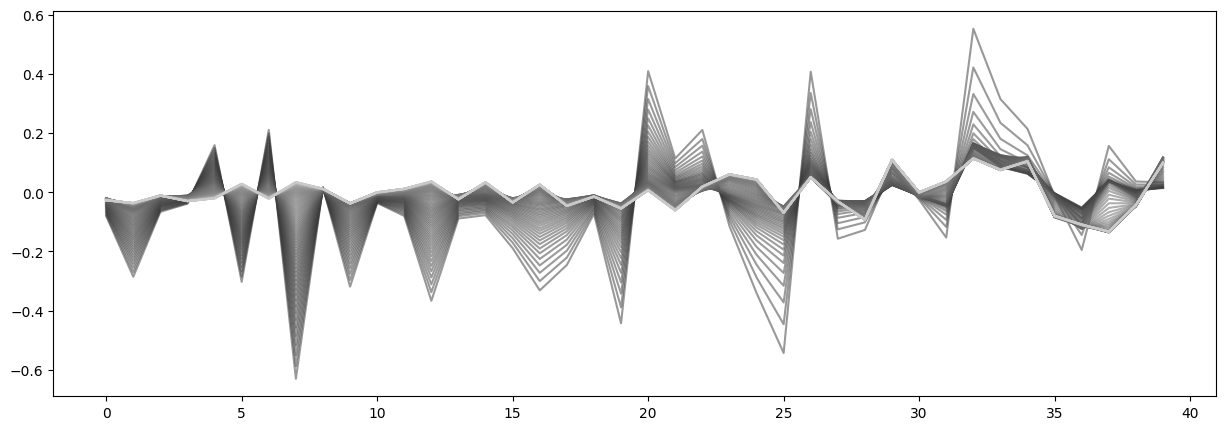

In [29]:
fig, axs = plot_rf_evolution(np.dot(weights, evecs), num_cols=1, num_rows=1)

#### Numerically solve ODE

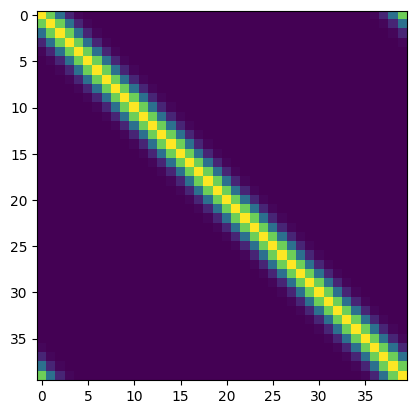

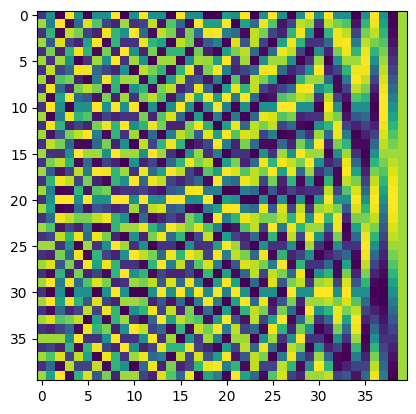

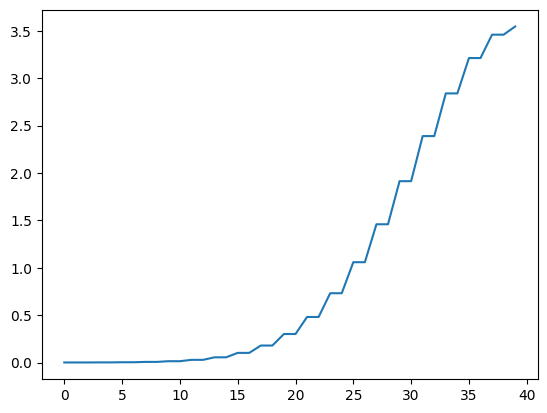

In [11]:
def build_gaussian_covariance(L, xi):
    C = np.abs(jnp.tile(jnp.arange(L)[:, jnp.newaxis], (1, L)) - jnp.tile(jnp.arange(L), (L, 1)))
    C = jnp.minimum(C, L - C)
    C = np.exp(-C ** 2 / (xi ** 2))
    return C

Sigma = build_gaussian_covariance(config['num_dimensions'], config['xi1'])
evals, evecs = np.linalg.eigh(Sigma)

_ = plt.imshow(Sigma)
plt.show()
_ = plt.imshow(evecs)
plt.show()
_ = plt.plot(evals)

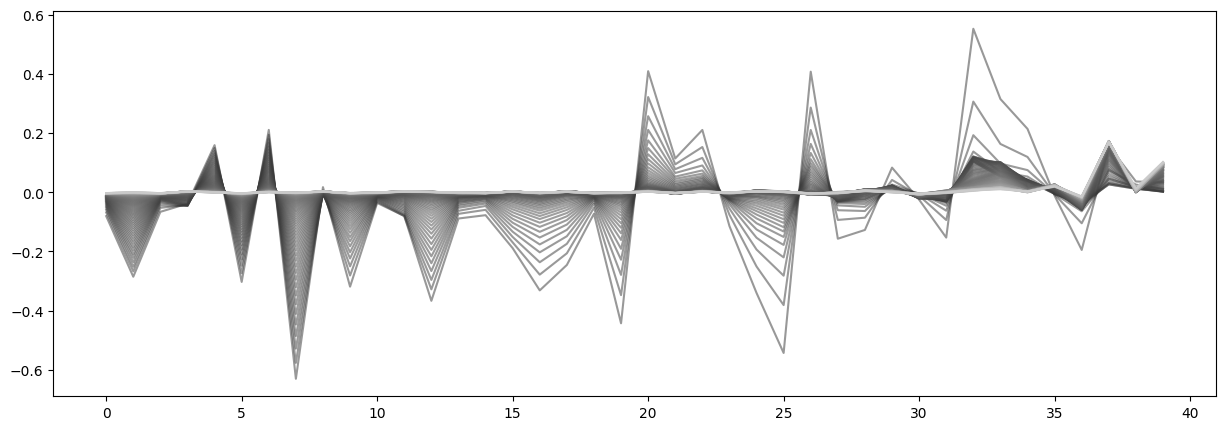

In [21]:
fig, axs = plot_rf_evolution(np.dot(weights, evecs), num_cols=1, num_rows=1)

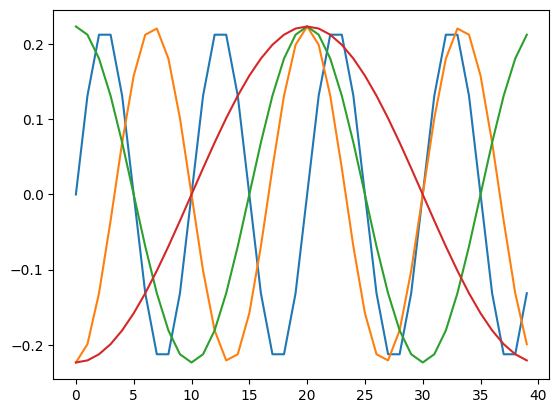

In [361]:
# plt.plot(evecs[:,-8:-4])
plt.plot(evecs[:,::2][:,-4:])

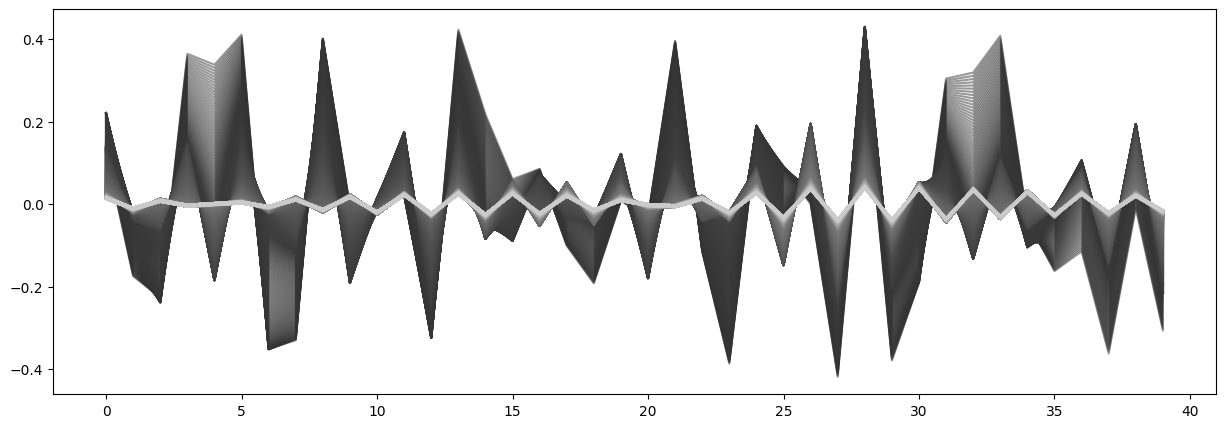

In [341]:
num_epochs_ = config['num_epochs']
u1 = np.zeros((num_epochs_, config['num_dimensions']))
w1_ = weights[0][0]
u1[0] = evecs.T @ w1_
lr_ = config['learning_rate']
Lambda = np.diag(evals)

for t in range(1,num_epochs_):
    u1_ = u1[t-1]
    du1 = (-2) * np.sqrt(2/np.pi) / np.sqrt( u1_ @ Lambda @ u1_ ) * (Lambda @ u1_)
    u1[t] = u1_ + lr_ * du1
    
w1 = (u1 @ evecs.T)

# fig, axs = plot_rf_evolution(u1.reshape(-1, 1, config['num_dimensions']), num_cols=1, num_rows=1)
fig, axs = plot_rf_evolution(w1.reshape(-1, 1, config['num_dimensions']), num_cols=1, num_rows=1)

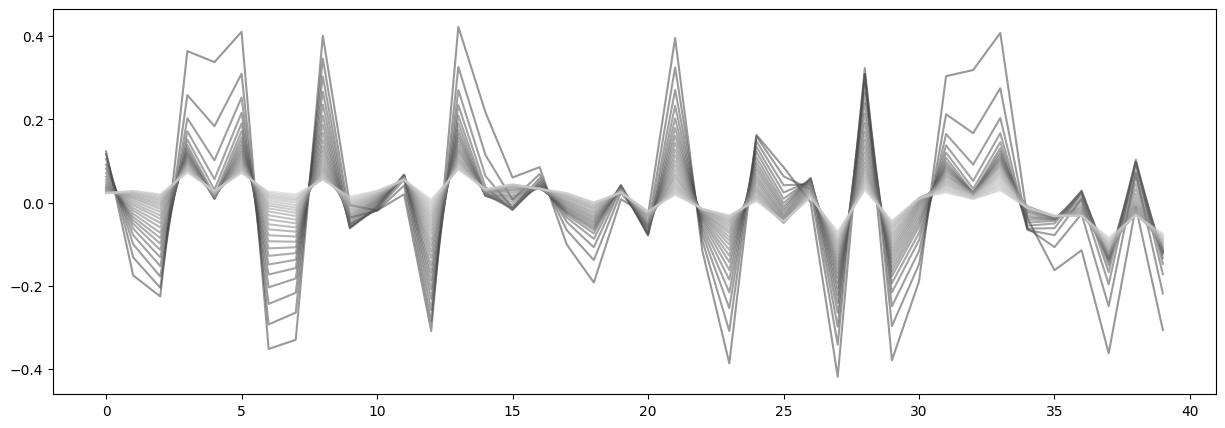

In [342]:
fig, axs = plot_rf_evolution(weights[:25].reshape(-1, 1, config['num_dimensions']), num_cols=1, num_rows=1)

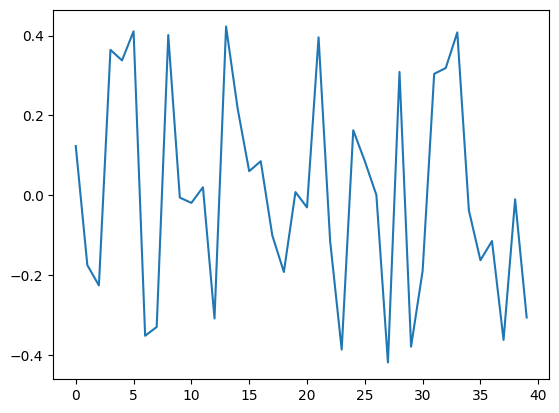

In [301]:
plt.plot(w1[0])

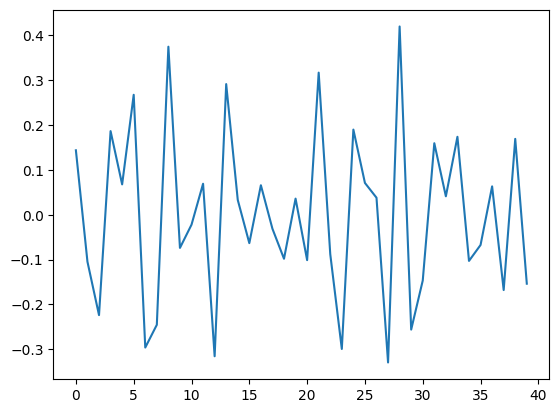

In [302]:
plt.plot(w1[40])

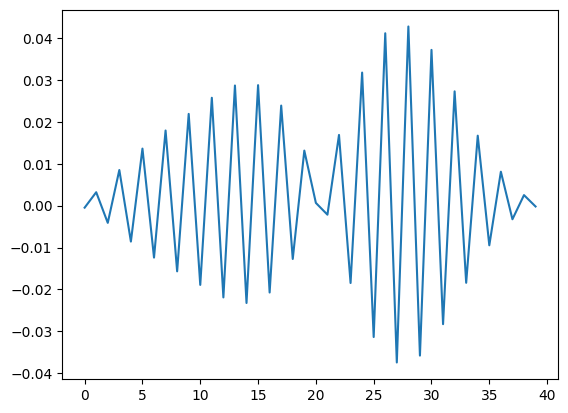

In [303]:
plt.plot(w1[-1])

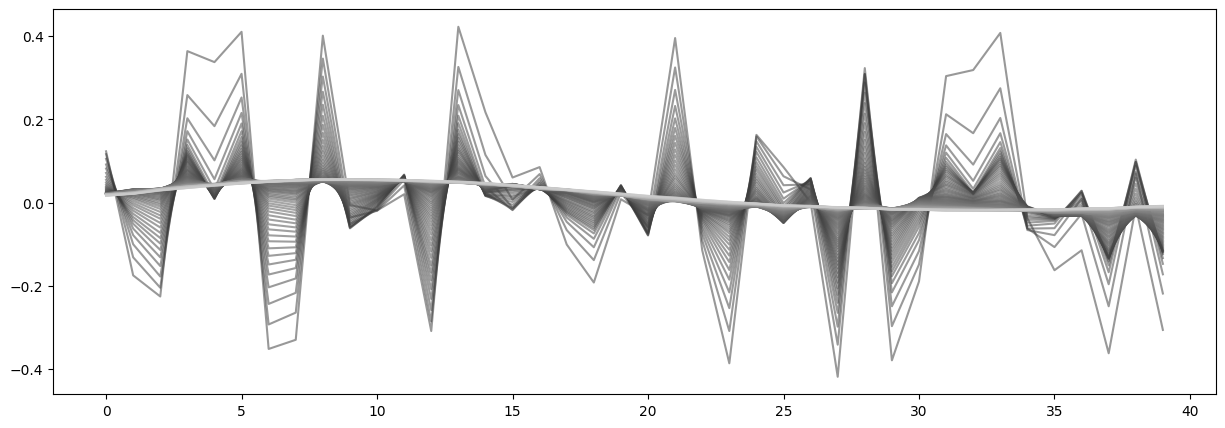

In [304]:
fig, axs = plot_rf_evolution(weights, num_cols=1, num_rows=1)

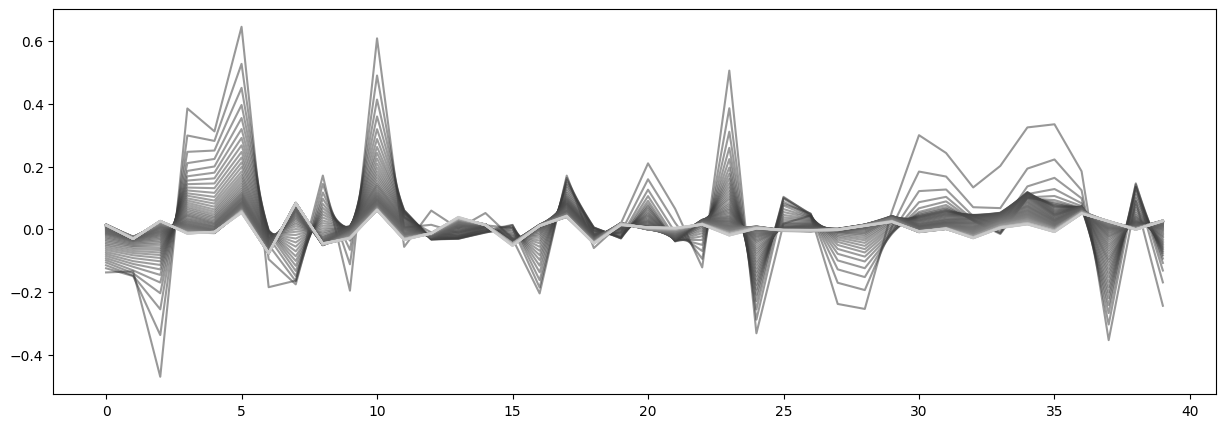

In [305]:
uweights = weights.reshape(-1, config['num_dimensions']) @ evecs.T
fig, axs = plot_rf_evolution(uweights.reshape(-1, 1, config['num_dimensions']), num_cols=1, num_rows=1)

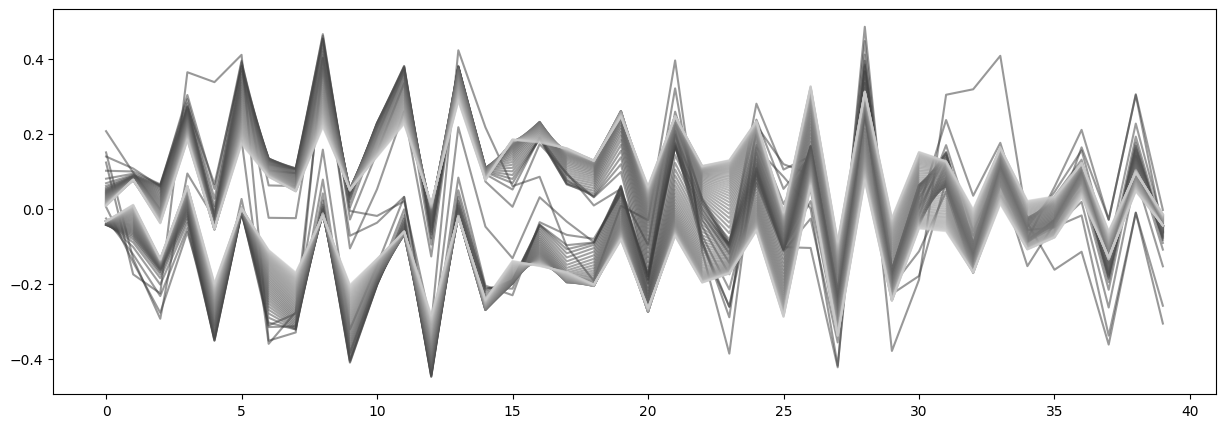

In [193]:
w1 = np.zeros((config['num_epochs'], config['num_dimensions']))
w1[0] = weights[0][0]
lr_ = config['learning_rate']

for t in range(1,config['num_epochs']):
    w1_ = w1[t-1]
    dw1 = (-2) * np.sqrt(2/np.pi) / np.sqrt( w1_ @ Sigma @ w1_ ) * (Sigma @ w1_)
    w1[t] = w1_ + lr_ * dw1
    
fig, axs = plot_rf_evolution(w1.reshape(-1, 1, config['num_dimensions']), num_cols=1, num_rows=1)

#### More direct simulation of ReLU network

In [247]:
config['gain'] = 0.001
dataset = datasets.NonlinearGPDataset(key=jax.random.PRNGKey(0), **config, num_exemplars=10000)
x, y = dataset[:10000]
lr_ = config['learning_rate']

In [268]:
w1 = np.zeros((config['num_epochs'], config['num_dimensions']))
w1[0] = weights[0][0]
w1_ = w1[0]
lr_ = 0.01

for t in range(1,config['num_epochs']):
    w1_ = w1[t-1]
    gate = (x @ w1_) > 0
    x_, y_ = x[gate], y[gate]
    
    # eqn (46)
    p = x @ w1_
    dw1 = np.mean( ((jax.nn.relu( p ) - y) * (p > 0).astype(int)).reshape(-1, 1) * x, axis=0 )
    
    # eqn (47)
    # dw1 = ((x_ @ w1_ - y_) @ x_) / len(x_) * np.mean(gate)
    
    # eqn (48)
    # xx = x_.T @ x_ / len(x_)
    # yx = np.mean(y_.reshape(-1, 1) * x_, axis=0)
    # dw1 = (xx @ w1_ - yx) * np.mean(gate)
    
    w1[t] = w1_ + lr_ * dw1
    # break

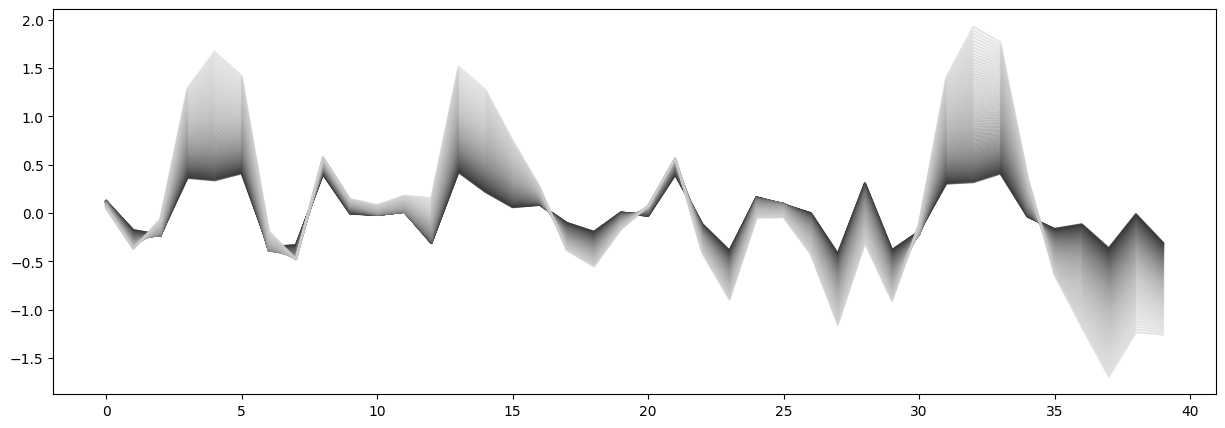

In [269]:
fig, axs = plot_rf_evolution(w1.reshape(-1, 1, config['num_dimensions']), num_cols=1, num_rows=1)

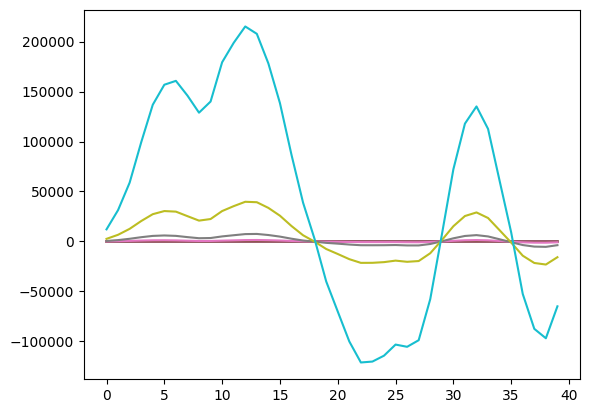

In [228]:
plt.plot(w1[:20][::2].T)

### Nonlinearity properties

As $g$ gets large, $\frac{1}{Z(g)} \text{erf}(g z_i) \to \text{sign}(z_i)$.
So, for $x \in \{ \pm 1 \}^n$,
$$
    \mathbb{P}( X = x )
    = \mathbb{P}( \text{sign}(Z) = x )
    = \mathbb{P}( \forall i: x_i Z_i > 0 ).
$$

In [ ]:
def build_gaussian_covariance(L, xi):
    C = np.abs(jnp.tile(jnp.arange(L)[:, jnp.newaxis], (1, L)) - jnp.tile(jnp.arange(L), (L, 1)))
    C = jnp.minimum(C, L - C)
    C = np.exp(-C ** 2 / (xi ** 2))
    return C
# evals, evecs = np.linalg.eigh(Sigma)

In [410]:
L = 14 # config['num_dimensions']
N = 1000000
xi = 3. # config['xi1']
Sigma = build_gaussian_covariance(L, xi)
x_ = np.random.multivariate_normal(np.zeros(L), Sigma, size=(N,))

/var/folders/gq/3xlhh9496_j9xpjb7tkbqh280000gn/T/ipykernel_94977/1239668083.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  x_ = np.random.multivariate_normal(np.zeros(L), Sigma, size=(N,))


In [413]:
# x = 2 * np.random.randint(0, 2, (N,L)) - 1
x = -np.ones(L)
np.all(np.sign(x_) == x, axis=1).mean()

0.064933